In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft,irfft
from matplotlib.colors import LogNorm

In [2]:
Npix = 2**12
Npad = 2**8
Nfft = Npix*Npad

def freq2lam(freq_MHz):
    return 3e8/(freq_MHz*1e6)

def image2uv(image):
    assert(len(image)==Npix)
    bigimage = np.zeros(Npix*Npad)
    bigimage[:Npix//2] = image[-Npix//2:]
    bigimage[-Npix//2:] = image[:Npix//2]
    return rfft(bigimage)

def uv2image(uv):
    #print (len(uv))
    assert(len(uv) == Nfft//2+1)
    bigimage = irfft(uv)
    image = np.hstack((bigimage[-Npix//2:],bigimage[:Npix//2]))
    return image

def alpha():
    return (np.arange(-Npix//2,Npix//2)+0.5)*(2/Npix)

def DoL():
    return np.arrange(Nfft//2+1)/Npad/2

def empty_uv():
    return np.zeros(Nfft//2+1,np.complex)

def empty_image():
    return np.zeros(Npix,np.float)

def DoL2ndx (DoL):
    return int(DoL*Npad*2+0.5) ## nearest integer

def primary_beam_1(D,freq_MHz):
    lam = freq2lam(freq_MHz)
    t=empty_uv()
    t[:DoL2ndx(D/lam/2)]=1.0
    return uv2image(t)
    
    



[]

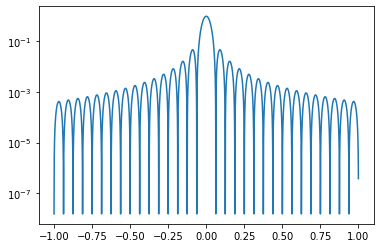

In [3]:
pbeam = primary_beam_1(6,800)**2 
plt.plot(alpha(),pbeam/pbeam.max())
plt.semilogy()

In [4]:
## Telescope sim

Nfreq = 256
freqs = np.linspace(400,800,Nfreq)
Ndishes = 32
lams = freq2lam(freqs)
DDish = 6
## this is a now 2D array of (numfreqs x Nbaselines) containg D/lambda for each
DoLams = np.outer(1/lams, DDish*np.arange(0,Ndishes))
## this is now an array of indices in the uv plane
indices = (DoLams*Npad*2+0.5).astype(int)

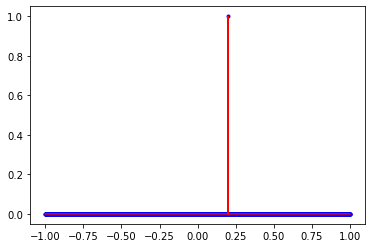

In [5]:
## Let's find a response to a point source
image = empty_image()
ndx = int(Npix*60/100)
image[ndx] = 1
plt.plot(alpha(),image,'b.')
plt.plot(alpha(),uv2image(image2uv(image)),'r-')
al = alpha()[ndx]
image.shape,Npix
## let's ignore beam for now
uv=image2uv(image)
uvplane = uv[indices]


/home/anze/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/anze/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'visibility')

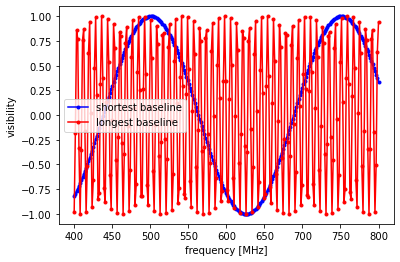

In [6]:
plt.plot(freqs,uvplane[:,1],'b.-', label='shortest baseline')

plt.plot(freqs,uvplane[:,Ndishes-1],'r.-', label='longest baseline')
plt.legend()
plt.xlabel('frequency [MHz]')
plt.ylabel('visibility')

/home/anze/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


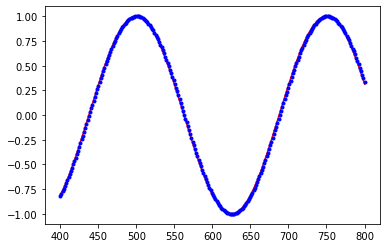

In [7]:
#compare with analytics
direct = np.cos(DDish/lams*2*np.pi*al)
plt.plot(freqs,direct,'r-')
plt.plot(freqs,uvplane[:,1],'b.')

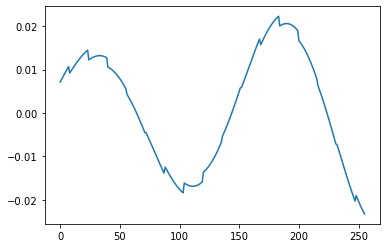

In [8]:
## we can now see interpolation errors. The scheme is percent accurate
plt.plot(direct-np.real(uvplane[:,1]))

In [9]:
## let's try to image this back
rmap = []
halfindices = (indices[:,:-1]+indices[:,1:])//2
halfindices = np.hstack((halfindices,2*indices[:,-1:]-halfindices[:,-1:]))
for i,f in enumerate(freqs):
    uvi=empty_uv()
    #for k in range(1,Ndishes):
    #    uvi[halfindices[i,k-1]:halfindices[i,k]]=uvplane[i,k]
    uvi[indices[i,1:]] = uvplane[i,1:]
    rmap.append(uv2image(uvi))
rmap = np.array(rmap)

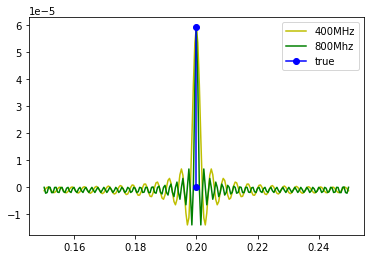

In [10]:
alp = alpha()
wal = np.where((alp>al-0.05) & (alp<al+0.05))
plt.plot(alpha()[wal],rmap[0,wal[0]],'y-',label='400MHz')
plt.plot(alpha()[wal],rmap[255,wal[0]],'g-',label='800Mhz')
plt.plot([al,al],[0,rmap.max()],'bo-',label='true')
plt.legend()

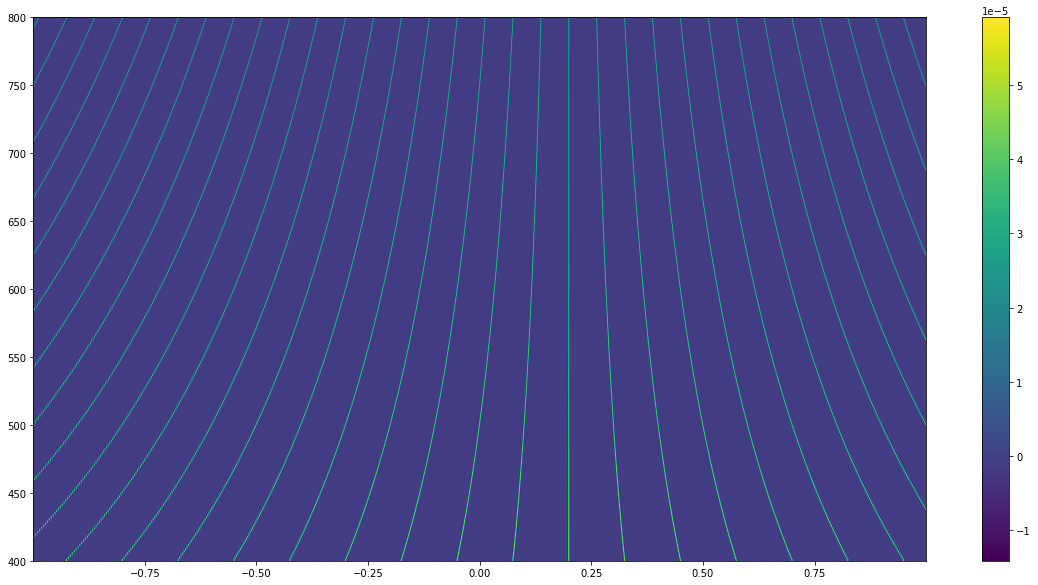

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(rmap,aspect='auto',origin='lower',extent=(alpha()[0],alpha()[-1],freqs[0],freqs[-1]))
plt.colorbar()

In [12]:
## Now let's plot some wedge.

### now we will just simulate various skies with point sources, which are flat in frequency, so only one FFT
### then do the fft along the frequency direction and hopefully see the wedge. WE need to do this for many realizations of the
### sky to get statistics

Nrel = 100
## let's make dishes smaller to see horizon more clearly -- hence 1/5 below
p2fac = [np.abs(primary_beam_1(DDish,f)**2)/np.cos(alpha()) for f in freqs]
uvplane = np.zeros((Nfreq,Ndishes),np.complex)
ps = np.zeros((Nfreq+1,Ndishes)) ## 2*Nfreq //2  +1 = Nfreq+1
for c in range(Nrel):
    ## create a random sky, this sky will be the same at all frequencies
    sky = np.random.uniform(0,1,Npix)
    ## loop over frequencies
    for i,f in enumerate(freqs):
        ## multiply by the beam ** 2 / cos
        msky = sky * p2fac[i]
        ## FT to the uvplane and sample at indicies corresponding to dist/lam 
        ## for this frequencies for the sate of dishes that we have
        uvplane[i,:]=image2uv(msky)[indices[i,:]]
    ## after uvplan is done, calculate ps in the frequency direction -- this gives delay spectrum
    for j in range(Ndishes):
        ps[:,j] += np.abs(rfft(np.hstack((uvplane [:,j],np.zeros(Nfreq))))**2)
        
    

/home/anze/anaconda3/lib/python3.6/site-packages/numpy/fft/_pocketfft.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


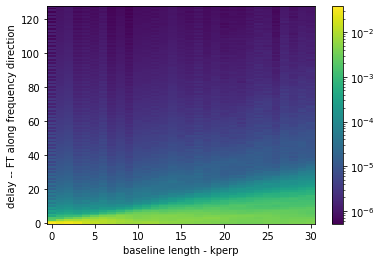

In [14]:
plt.imshow(ps[:128,1:],origin='lower',aspect='auto',interpolation='nearest', norm=LogNorm())
plt.xlabel("baseline length - kperp")
plt.ylabel("delay -- FT along frequency direction")
plt.colorbar()